# Ensemble Model Analysis

This notebook implements various ensemble strategies to combine models both per location and cross-location to improve forecasting performance. It includes voting, stacking, weighted averaging, and meta-learning approaches.


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Data processing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

# Traditional ML models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

# Time series models
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Nixtla client for TimeGPT
from nixtla import NixtlaClient

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully!")


Libraries imported successfully!


In [2]:
# Load the consolidated data
df = pd.read_csv('../outputs/data/sales_weather_merged_filled_consolidated.csv')
print(f"Data shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Locations: {df['Location'].unique()}")

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['Location', 'date']).reset_index(drop=True)

# Load previous results for reference
try:
    original_results = pd.read_csv('../outputs/model_results/location_model_comparison_corrected.csv')
    print(f"\nOriginal results shape: {original_results.shape}")
    print("Best models per location from original analysis:")
    best_models = original_results.loc[original_results.groupby('Location')['MAE'].idxmin()]
    print(best_models[['Location', 'Model_Type', 'Model_Name', 'MAE', 'R2']].round(3))
except:
    print("Original results not found, will use default best models")
    best_models = None

df.head()


Data shape: (286, 18)
Date range: 2019-04-01 to 2024-03-01
Locations: ['Bangalore' 'Chennai' 'Cochin' 'Secunderabad' 'Vijaywada' 'Sricity']

Original results shape: (116, 8)
Best models per location from original analysis:
         Location   Model_Type         Model_Name       MAE     R2
20      Bangalore  Time Series             SARIMA   692.395  0.755
45        Chennai  Time Series                ETS  3187.251  0.199
54         Cochin           ML        Extra Trees  2911.539  0.095
75   Secunderabad           ML  Gradient Boosting  4672.800  0.263
112     Vijaywada  Time Series             SARIMA  2788.553  0.144


,Location,QTY,temp_min,temp_max,temp_mean,dwpt_min,dwpt_max,dwpt_mean,rhum_min,rhum_max,rhum_mean,prcp_min,prcp_max,prcp_mean,wspd_min,wspd_max,wspd_mean,date
0,Bangalore,1678.0,15.0,34.40,25.490457,-2.240,21.820,12.241344,11.20,99.6,49.995161,0.0,1.875000,0.009845,1.08,34.480,10.858306,2019-04-01
1,Bangalore,3951.0,19.0,35.25,27.041071,0.775,23.275,15.193029,12.25,100.0,54.193651,0.0,7.766667,0.056111,0.00,36.625,10.347719,2019-05-01
2,Bangalore,4709.0,19.6,34.40,26.270377,10.240,24.420,19.395948,24.80,100.0,69.900511,0.0,8.166667,0.159319,0.00,38.960,13.101580,2019-06-01
3,Bangalore,2418.0,19.6,32.40,24.810296,14.280,24.020,19.992738,38.00,100.0,76.857086,0.0,7.800000,0.155787,1.44,41.540,17.832391,2019-07-01
4,Bangalore,2252.0,19.6,30.40,23.654283,16.740,23.260,20.154345,45.40,100.0,82.423583,0.0,7.633333,0.201703,1.44,41.600,18.792103,2019-08-01


In [3]:
# Import helper functions from previous notebooks
def create_time_features(df):
    """
    Create comprehensive time-based features for forecasting
    """
    df = df.copy()
    
    # Extract temporal indicators
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['quarter'] = df['date'].dt.quarter
    df['day_of_year'] = df['date'].dt.dayofyear
    df['week_of_year'] = df['date'].dt.isocalendar().week
    df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
    df['is_quarter_start'] = df['date'].dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df['date'].dt.is_quarter_end.astype(int)
    
    # Cyclical encoding for seasonality
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['quarter_sin'] = np.sin(2 * np.pi * df['quarter'] / 4)
    df['quarter_cos'] = np.cos(2 * np.pi * df['quarter'] / 4)
    
    # Weather interaction features
    if 'temp_mean' in df.columns and 'rhum_mean' in df.columns:
        df['temp_humidity_interaction'] = df['temp_mean'] * df['rhum_mean']
    if 'temp_mean' in df.columns and 'wspd_mean' in df.columns:
        df['temp_wind_interaction'] = df['temp_mean'] * df['wspd_mean']
    
    return df

def create_lag_and_rolling_features(df, target_col='QTY', lags=[1, 2, 3, 6, 12], windows=[3, 6, 12]):
    """
    Create lag and rolling features to prevent data leakage
    """
    df = df.copy()
    
    # Create lag features (only using past data)
    for lag in lags:
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
    
    # Create rolling statistics (only using past data)
    for window in windows:
        df[f'{target_col}_rolling_mean_{window}'] = df[target_col].rolling(window=window, min_periods=1).mean().shift(1)
        df[f'{target_col}_rolling_std_{window}'] = df[target_col].rolling(window=window, min_periods=1).std().shift(1)
        df[f'{target_col}_rolling_min_{window}'] = df[target_col].rolling(window=window, min_periods=1).min().shift(1)
        df[f'{target_col}_rolling_max_{window}'] = df[target_col].rolling(window=window, min_periods=1).max().shift(1)
    
    return df

def prepare_location_data(df, location, test_months=12):
    """
    Prepare data for a specific location with train/test split
    """
    # Filter data for specific location
    location_df = df[df['Location'] == location].copy()
    location_df = location_df.sort_values('date').reset_index(drop=True)
    
    # Check if we have enough data
    if len(location_df) < test_months + 12:  # Need at least 12 months for training + test_months
        print(f"Warning: {location} has insufficient data ({len(location_df)} records). Skipping.")
        return None
    
    # Create time features
    location_df = create_time_features(location_df)
    
    # Create lag and rolling features
    location_df = create_lag_and_rolling_features(location_df)
    
    # Split data: last test_months for testing
    split_idx = len(location_df) - test_months
    train_df = location_df.iloc[:split_idx].copy()
    test_df = location_df.iloc[split_idx:].copy()
    
    # Remove rows with NaN from lag/rolling features in training set
    train_df = train_df.dropna().reset_index(drop=True)
    
    # Check if we have any training data left
    if len(train_df) == 0:
        print(f"Warning: {location} has no valid training data after feature engineering. Skipping.")
        return None
    
    # Define feature columns (exclude target and non-feature columns)
    exclude_cols = ['QTY', 'date', 'Location']
    feature_cols = [col for col in location_df.columns if col not in exclude_cols]
    
    # Prepare features and target
    X_train = train_df[feature_cols].fillna(0)  # Fill any remaining NaN with 0
    y_train = train_df['QTY']
    X_test = test_df[feature_cols].fillna(0)
    y_test = test_df['QTY']
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return {
        'X_train': X_train_scaled,
        'X_test': X_test_scaled,
        'y_train': y_train.values,
        'y_test': y_test.values,
        'train_df': train_df,
        'test_df': test_df,
        'feature_cols': feature_cols,
        'scaler': scaler
    }

def calculate_metrics(y_true, y_pred):
    """
    Calculate evaluation metrics
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'R2': r2
    }

print("Helper functions loaded successfully!")


Helper functions loaded successfully!


In [4]:
# Define ensemble strategies
class EnsembleForecaster:
    """
    Ensemble forecasting class that implements various ensemble strategies
    """
    
    def __init__(self):
        self.models = {}
        self.weights = {}
        self.meta_model = None
        
    def add_model(self, name, model, weight=1.0):
        """Add a model to the ensemble"""
        self.models[name] = model
        self.weights[name] = weight
        
    def simple_average(self, predictions):
        """Simple average of all predictions"""
        return np.mean(predictions, axis=0)
    
    def weighted_average(self, predictions):
        """Weighted average based on model weights"""
        weights = np.array(list(self.weights.values()))
        weights = weights / weights.sum()  # Normalize weights
        return np.average(predictions, axis=0, weights=weights)
    
    def performance_weighted_average(self, predictions, model_performance):
        """Weighted average based on model performance (inverse of MAE)"""
        # Convert MAE to weights (lower MAE = higher weight)
        weights = 1.0 / (model_performance + 1e-8)  # Add small epsilon to avoid division by zero
        weights = weights / weights.sum()  # Normalize weights
        return np.average(predictions, axis=0, weights=weights)
    
    def median_ensemble(self, predictions):
        """Median of all predictions"""
        return np.median(predictions, axis=0)
    
    def trimmed_mean(self, predictions, trim_percent=0.1):
        """Trimmed mean (remove extreme predictions)"""
        n_models = len(predictions)
        trim_count = int(n_models * trim_percent)
        if trim_count > 0:
            # Sort and trim extreme values
            sorted_preds = np.sort(predictions, axis=0)
            trimmed_preds = sorted_preds[trim_count:-trim_count] if trim_count > 0 else sorted_preds
            return np.mean(trimmed_preds, axis=0)
        else:
            return np.mean(predictions, axis=0)
    
    def dynamic_weighted_average(self, predictions, recent_performance):
        """Dynamic weighting based on recent performance"""
        # Use exponential decay for recent performance
        weights = np.exp(-recent_performance / np.mean(recent_performance))
        weights = weights / weights.sum()
        return np.average(predictions, axis=0, weights=weights)

def create_ml_models():
    """Create a collection of ML models for ensemble"""
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge': Ridge(alpha=1.0),
        'Lasso': Lasso(alpha=0.1),
        'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
        'AdaBoost': AdaBoostRegressor(n_estimators=100, random_state=42),
        'Extra Trees': ExtraTreesRegressor(n_estimators=100, random_state=42),
        'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
        'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42, verbosity=-1),
        'CatBoost': CatBoostRegressor(iterations=100, random_state=42, verbose=False),
        'SVR': SVR(kernel='rbf'),
        'KNN': KNeighborsRegressor(n_neighbors=5)
    }
    return models

def train_ml_models(X_train, y_train, X_test, y_test):
    """Train all ML models and return predictions"""
    models = create_ml_models()
    predictions = {}
    model_performance = {}
    
    for name, model in models.items():
        try:
            # Train model
            model.fit(X_train, y_train)
            
            # Make predictions
            y_pred = model.predict(X_test)
            predictions[name] = y_pred
            
            # Calculate performance
            mae = mean_absolute_error(y_test, y_pred)
            model_performance[name] = mae
            
            print(f"✓ {name}: MAE={mae:.2f}")
            
        except Exception as e:
            print(f"✗ {name}: Failed - {str(e)}")
    
    return predictions, model_performance

print("Ensemble classes and functions defined successfully!")


Ensemble classes and functions defined successfully!


In [5]:
# Per-Location Ensemble Analysis
print("PER-LOCATION ENSEMBLE ANALYSIS")
print("="*60)

# Get all locations
all_locations = df['Location'].unique()
print(f"Locations to analyze: {all_locations}")

# Initialize results storage
per_location_ensemble_results = []

# Analyze each location
for location in all_locations:
    print(f"\n{'='*60}")
    print(f"Analyzing Location: {location}")
    print(f"{'='*60}")
    
    # Prepare data for location
    location_data = prepare_location_data(df, location)
    
    if location_data is None:
        print(f"Skipping {location} - insufficient data")
        continue
    
    print(f"Training samples: {len(location_data['y_train'])}")
    print(f"Test samples: {len(location_data['y_test'])}")
    
    # Train individual ML models
    print("\n--- Training Individual ML Models ---")
    individual_predictions, model_performance = train_ml_models(
        location_data['X_train'],
        location_data['y_train'],
        location_data['X_test'],
        location_data['y_test']
    )
    
    if len(individual_predictions) == 0:
        print("No models trained successfully")
        continue
    
    # Create ensemble forecaster
    ensemble = EnsembleForecaster()
    
    # Add models to ensemble
    for name, pred in individual_predictions.items():
        ensemble.add_model(name, None, weight=1.0)
    
    # Convert predictions to array format
    pred_array = np.array(list(individual_predictions.values()))
    model_names = list(individual_predictions.keys())
    performance_array = np.array([model_performance[name] for name in model_names])
    
    # Test different ensemble strategies
    ensemble_strategies = {
        'Simple Average': ensemble.simple_average(pred_array),
        'Weighted Average': ensemble.weighted_average(pred_array),
        'Performance Weighted': ensemble.performance_weighted_average(pred_array, performance_array),
        'Median Ensemble': ensemble.median_ensemble(pred_array),
        'Trimmed Mean (10%)': ensemble.trimmed_mean(pred_array, trim_percent=0.1),
        'Trimmed Mean (20%)': ensemble.trimmed_mean(pred_array, trim_percent=0.2)
    }
    
    print(f"\n--- Ensemble Results for {location} ---")
    
    # Evaluate each ensemble strategy
    for strategy_name, ensemble_pred in ensemble_strategies.items():
        metrics = calculate_metrics(location_data['y_test'], ensemble_pred)
        
        per_location_ensemble_results.append({
            'Location': location,
            'Strategy': strategy_name,
            'MAE': metrics['MAE'],
            'RMSE': metrics['RMSE'],
            'MAPE': metrics['MAPE'],
            'R2': metrics['R2']
        })
        
        print(f"✓ {strategy_name}: MAE={metrics['MAE']:.2f}, RMSE={metrics['RMSE']:.2f}, R²={metrics['R2']:.3f}")
    
    # Find best individual model for comparison
    best_individual_mae = min(model_performance.values())
    best_individual_name = min(model_performance, key=model_performance.get)
    print(f"\nBest Individual Model: {best_individual_name} (MAE={best_individual_mae:.2f})")
    
    # Find best ensemble strategy
    ensemble_results = [r for r in per_location_ensemble_results if r['Location'] == location]
    best_ensemble = min(ensemble_results, key=lambda x: x['MAE'])
    print(f"Best Ensemble Strategy: {best_ensemble['Strategy']} (MAE={best_ensemble['MAE']:.2f})")
    
    # Improvement analysis
    improvement = ((best_individual_mae - best_ensemble['MAE']) / best_individual_mae) * 100
    print(f"Ensemble Improvement: {improvement:.2f}%")

print(f"\n{'='*60}")
print(f"Per-location ensemble analysis completed!")
print(f"Total results: {len(per_location_ensemble_results)}")
print(f"{'='*60}")


PER-LOCATION ENSEMBLE ANALYSIS
Locations to analyze: ['Bangalore' 'Chennai' 'Cochin' 'Secunderabad' 'Sricity' 'Vijaywada']

Analyzing Location: Bangalore
Training samples: 35
Test samples: 12

--- Training Individual ML Models ---
✓ Linear Regression: MAE=14860.14
✓ Ridge: MAE=2682.93
✓ Lasso: MAE=5004.74
✓ ElasticNet: MAE=2325.34
✓ Random Forest: MAE=1692.50
✓ Gradient Boosting: MAE=1677.89
✓ AdaBoost: MAE=1255.89
✓ Extra Trees: MAE=1896.71
✓ XGBoost: MAE=1609.18
✓ LightGBM: MAE=1958.58
✓ CatBoost: MAE=1532.17
✓ SVR: MAE=2666.99
✓ KNN: MAE=1721.38

--- Ensemble Results for Bangalore ---
✓ Simple Average: MAE=2698.29, RMSE=4118.90, R²=-1.805
✓ Weighted Average: MAE=2698.29, RMSE=4118.90, R²=-1.805
✓ Performance Weighted: MAE=1761.73, RMSE=2423.33, R²=0.029
✓ Median Ensemble: MAE=1659.61, RMSE=2207.89, R²=0.194
✓ Trimmed Mean (10%): MAE=1886.90, RMSE=2739.08, R²=-0.240
✓ Trimmed Mean (20%): MAE=1796.42, RMSE=2506.06, R²=-0.038

Best Individual Model: AdaBoost (MAE=1255.89)
Best Ensemble

In [6]:
# Cross-Location Ensemble Analysis
print("\n" + "="*80)
print("CROSS-LOCATION ENSEMBLE ANALYSIS")
print("="*80)

# Initialize cross-location ensemble results
cross_location_ensemble_results = []

# For each location, create ensemble using models from other locations
for target_location in all_locations:
    print(f"\n{'='*60}")
    print(f"Cross-Location Ensemble for Target: {target_location}")
    print(f"{'='*60}")
    
    # Prepare data for target location
    target_data = prepare_location_data(df, target_location)
    
    if target_data is None:
        print(f"Skipping {target_location} - insufficient data")
        continue
    
    # Get predictions from models trained on other locations
    other_locations = [loc for loc in all_locations if loc != target_location]
    cross_location_predictions = {}
    cross_location_performance = {}
    
    print(f"Training models on other locations: {other_locations}")
    
    for source_location in other_locations:
        print(f"\nTraining on {source_location} for {target_location}...")
        
        # Prepare data for source location
        source_data = prepare_location_data(df, source_location)
        
        if source_data is None:
            print(f"  Skipping {source_location} - insufficient data")
            continue
        
        # Train models on source location
        source_predictions, source_performance = train_ml_models(
            source_data['X_train'],
            source_data['y_train'],
            target_data['X_test'],
            target_data['y_test']
        )
        
        # Store predictions with source location prefix
        for model_name, pred in source_predictions.items():
            cross_location_predictions[f"{source_location}_{model_name}"] = pred
            cross_location_performance[f"{source_location}_{model_name}"] = source_performance[model_name]
    
    if len(cross_location_predictions) == 0:
        print(f"No cross-location models trained for {target_location}")
        continue
    
    # Create cross-location ensemble
    cross_ensemble = EnsembleForecaster()
    
    # Add models to ensemble
    for name, pred in cross_location_predictions.items():
        cross_ensemble.add_model(name, None, weight=1.0)
    
    # Convert predictions to array format
    cross_pred_array = np.array(list(cross_location_predictions.values()))
    cross_model_names = list(cross_location_predictions.keys())
    cross_performance_array = np.array([cross_location_performance[name] for name in cross_model_names])
    
    # Test different ensemble strategies for cross-location
    cross_ensemble_strategies = {
        'Cross-Location Simple Average': cross_ensemble.simple_average(cross_pred_array),
        'Cross-Location Weighted Average': cross_ensemble.weighted_average(cross_pred_array),
        'Cross-Location Performance Weighted': cross_ensemble.performance_weighted_average(cross_pred_array, cross_performance_array),
        'Cross-Location Median': cross_ensemble.median_ensemble(cross_pred_array),
        'Cross-Location Trimmed Mean (10%)': cross_ensemble.trimmed_mean(cross_pred_array, trim_percent=0.1),
        'Cross-Location Trimmed Mean (20%)': cross_ensemble.trimmed_mean(cross_pred_array, trim_percent=0.2)
    }
    
    print(f"\n--- Cross-Location Ensemble Results for {target_location} ---")
    
    # Evaluate each cross-location ensemble strategy
    for strategy_name, ensemble_pred in cross_ensemble_strategies.items():
        metrics = calculate_metrics(target_data['y_test'], ensemble_pred)
        
        cross_location_ensemble_results.append({
            'Target_Location': target_location,
            'Strategy': strategy_name,
            'MAE': metrics['MAE'],
            'RMSE': metrics['RMSE'],
            'MAPE': metrics['MAPE'],
            'R2': metrics['R2']
        })
        
        print(f"✓ {strategy_name}: MAE={metrics['MAE']:.2f}, RMSE={metrics['RMSE']:.2f}, R²={metrics['R2']:.3f}")
    
    # Find best cross-location ensemble strategy
    cross_ensemble_results = [r for r in cross_location_ensemble_results if r['Target_Location'] == target_location]
    if cross_ensemble_results:
        best_cross_ensemble = min(cross_ensemble_results, key=lambda x: x['MAE'])
        print(f"Best Cross-Location Ensemble: {best_cross_ensemble['Strategy']} (MAE={best_cross_ensemble['MAE']:.2f})")

print(f"\n{'='*80}")
print(f"Cross-location ensemble analysis completed!")
print(f"Total cross-location results: {len(cross_location_ensemble_results)}")
print(f"{'='*80}")



CROSS-LOCATION ENSEMBLE ANALYSIS

Cross-Location Ensemble for Target: Bangalore
Training models on other locations: ['Chennai', 'Cochin', 'Secunderabad', 'Sricity', 'Vijaywada']

Training on Chennai for Bangalore...
✓ Linear Regression: MAE=405159.99
✓ Ridge: MAE=8344.38
✓ Lasso: MAE=13516.14
✓ ElasticNet: MAE=7200.35
✓ Random Forest: MAE=7641.66
✓ Gradient Boosting: MAE=7501.23
✓ AdaBoost: MAE=6023.23
✓ Extra Trees: MAE=6672.33
✓ XGBoost: MAE=3646.18
✓ LightGBM: MAE=7007.71
✓ CatBoost: MAE=6826.42
✓ SVR: MAE=4985.70
✓ KNN: MAE=4552.28

Training on Cochin for Bangalore...
✓ Linear Regression: MAE=22813.34
✓ Ridge: MAE=3030.06
✓ Lasso: MAE=6642.25
✓ ElasticNet: MAE=2765.02
✓ Random Forest: MAE=1713.84
✓ Gradient Boosting: MAE=1808.77
✓ AdaBoost: MAE=1741.76
✓ Extra Trees: MAE=1914.31
✓ XGBoost: MAE=1260.29
✓ LightGBM: MAE=2289.98
✓ CatBoost: MAE=1887.98
✓ SVR: MAE=2756.71
✓ KNN: MAE=2081.62

Training on Secunderabad for Bangalore...
✓ Linear Regression: MAE=157947.99
✓ Ridge: MAE=6088.

In [7]:
# Hybrid Ensemble: Combine Per-Location and Cross-Location
print("\n" + "="*80)
print("HYBRID ENSEMBLE ANALYSIS")
print("="*80)

# Initialize hybrid ensemble results
hybrid_ensemble_results = []

# For each location, create hybrid ensemble combining both approaches
for target_location in all_locations:
    print(f"\n{'='*60}")
    print(f"Hybrid Ensemble for Target: {target_location}")
    print(f"{'='*60}")
    
    # Prepare data for target location
    target_data = prepare_location_data(df, target_location)
    
    if target_data is None:
        print(f"Skipping {target_location} - insufficient data")
        continue
    
    # Get per-location predictions (models trained on same location)
    print("Training per-location models...")
    per_location_predictions, per_location_performance = train_ml_models(
        target_data['X_train'],
        target_data['y_train'],
        target_data['X_test'],
        target_data['y_test']
    )
    
    # Get cross-location predictions (models trained on other locations)
    print("Training cross-location models...")
    other_locations = [loc for loc in all_locations if loc != target_location]
    cross_location_predictions = {}
    cross_location_performance = {}
    
    for source_location in other_locations:
        source_data = prepare_location_data(df, source_location)
        if source_data is None:
            continue
        
        source_predictions, source_performance = train_ml_models(
            source_data['X_train'],
            source_data['y_train'],
            target_data['X_test'],
            target_data['y_test']
        )
        
        for model_name, pred in source_predictions.items():
            cross_location_predictions[f"{source_location}_{model_name}"] = pred
            cross_location_performance[f"{source_location}_{model_name}"] = source_performance[model_name]
    
    # Combine per-location and cross-location predictions
    all_predictions = {}
    all_performance = {}
    
    # Add per-location predictions
    for name, pred in per_location_predictions.items():
        all_predictions[f"PerLocation_{name}"] = pred
        all_performance[f"PerLocation_{name}"] = per_location_performance[name]
    
    # Add cross-location predictions
    for name, pred in cross_location_predictions.items():
        all_predictions[f"CrossLocation_{name}"] = pred
        all_performance[f"CrossLocation_{name}"] = cross_location_performance[name]
    
    if len(all_predictions) == 0:
        print(f"No hybrid models available for {target_location}")
        continue
    
    # Create hybrid ensemble
    hybrid_ensemble = EnsembleForecaster()
    
    # Add all models to hybrid ensemble
    for name, pred in all_predictions.items():
        hybrid_ensemble.add_model(name, None, weight=1.0)
    
    # Convert predictions to array format
    hybrid_pred_array = np.array(list(all_predictions.values()))
    hybrid_model_names = list(all_predictions.keys())
    hybrid_performance_array = np.array([all_performance[name] for name in hybrid_model_names])
    
    # Test different hybrid ensemble strategies
    hybrid_ensemble_strategies = {
        'Hybrid Simple Average': hybrid_ensemble.simple_average(hybrid_pred_array),
        'Hybrid Weighted Average': hybrid_ensemble.weighted_average(hybrid_pred_array),
        'Hybrid Performance Weighted': hybrid_ensemble.performance_weighted_average(hybrid_pred_array, hybrid_performance_array),
        'Hybrid Median': hybrid_ensemble.median_ensemble(hybrid_pred_array),
        'Hybrid Trimmed Mean (10%)': hybrid_ensemble.trimmed_mean(hybrid_pred_array, trim_percent=0.1),
        'Hybrid Trimmed Mean (20%)': hybrid_ensemble.trimmed_mean(hybrid_pred_array, trim_percent=0.2)
    }
    
    print(f"\n--- Hybrid Ensemble Results for {target_location} ---")
    
    # Evaluate each hybrid ensemble strategy
    for strategy_name, ensemble_pred in hybrid_ensemble_strategies.items():
        metrics = calculate_metrics(target_data['y_test'], ensemble_pred)
        
        hybrid_ensemble_results.append({
            'Target_Location': target_location,
            'Strategy': strategy_name,
            'MAE': metrics['MAE'],
            'RMSE': metrics['RMSE'],
            'MAPE': metrics['MAPE'],
            'R2': metrics['R2']
        })
        
        print(f"✓ {strategy_name}: MAE={metrics['MAE']:.2f}, RMSE={metrics['RMSE']:.2f}, R²={metrics['R2']:.3f}")
    
    # Find best hybrid ensemble strategy
    hybrid_ensemble_results_loc = [r for r in hybrid_ensemble_results if r['Target_Location'] == target_location]
    if hybrid_ensemble_results_loc:
        best_hybrid_ensemble = min(hybrid_ensemble_results_loc, key=lambda x: x['MAE'])
        print(f"Best Hybrid Ensemble: {best_hybrid_ensemble['Strategy']} (MAE={best_hybrid_ensemble['MAE']:.2f})")

print(f"\n{'='*80}")
print(f"Hybrid ensemble analysis completed!")
print(f"Total hybrid results: {len(hybrid_ensemble_results)}")
print(f"{'='*80}")



HYBRID ENSEMBLE ANALYSIS

Hybrid Ensemble for Target: Bangalore
Training per-location models...
✓ Linear Regression: MAE=14860.14
✓ Ridge: MAE=2682.93
✓ Lasso: MAE=5004.74
✓ ElasticNet: MAE=2325.34
✓ Random Forest: MAE=1692.50
✓ Gradient Boosting: MAE=1677.89
✓ AdaBoost: MAE=1255.89
✓ Extra Trees: MAE=1896.71
✓ XGBoost: MAE=1609.18
✓ LightGBM: MAE=1958.58
✓ CatBoost: MAE=1532.17
✓ SVR: MAE=2666.99
✓ KNN: MAE=1721.38
Training cross-location models...
✓ Linear Regression: MAE=405159.99
✓ Ridge: MAE=8344.38
✓ Lasso: MAE=13516.14
✓ ElasticNet: MAE=7200.35
✓ Random Forest: MAE=7641.66
✓ Gradient Boosting: MAE=7501.23
✓ AdaBoost: MAE=6023.23
✓ Extra Trees: MAE=6672.33
✓ XGBoost: MAE=3646.18
✓ LightGBM: MAE=7007.71
✓ CatBoost: MAE=6826.42
✓ SVR: MAE=4985.70
✓ KNN: MAE=4552.28
✓ Linear Regression: MAE=22813.34
✓ Ridge: MAE=3030.06
✓ Lasso: MAE=6642.25
✓ ElasticNet: MAE=2765.02
✓ Random Forest: MAE=1713.84
✓ Gradient Boosting: MAE=1808.77
✓ AdaBoost: MAE=1741.76
✓ Extra Trees: MAE=1914.31
✓ XG

In [8]:
# Save all ensemble results
import os
os.makedirs('../outputs/model_results', exist_ok=True)

# Convert results to DataFrames
per_location_df = pd.DataFrame(per_location_ensemble_results)
cross_location_df = pd.DataFrame(cross_location_ensemble_results)
hybrid_df = pd.DataFrame(hybrid_ensemble_results)

# Save results
per_location_df.to_csv('../outputs/model_results/per_location_ensemble_results.csv', index=False)
cross_location_df.to_csv('../outputs/model_results/cross_location_ensemble_results.csv', index=False)
hybrid_df.to_csv('../outputs/model_results/hybrid_ensemble_results.csv', index=False)

print(f"Results saved:")
print(f"- Per-location ensemble: {len(per_location_df)} results")
print(f"- Cross-location ensemble: {len(cross_location_df)} results")
print(f"- Hybrid ensemble: {len(hybrid_df)} results")


Results saved:
- Per-location ensemble: 30 results
- Cross-location ensemble: 30 results
- Hybrid ensemble: 30 results


In [9]:
# Comprehensive Ensemble Analysis
print("\n" + "="*80)
print("COMPREHENSIVE ENSEMBLE ANALYSIS")
print("="*80)

# 1. Per-Location Ensemble Analysis
print("\n--- Per-Location Ensemble Performance ---")
per_location_summary = per_location_df.groupby('Strategy').agg({
    'MAE': ['mean', 'std', 'min', 'max'],
    'RMSE': ['mean', 'std', 'min', 'max'],
    'R2': ['mean', 'std', 'min', 'max']
}).round(3)

print(per_location_summary)

# Best per-location strategy
best_per_location = per_location_df.groupby('Strategy')['MAE'].mean().idxmin()
best_per_location_mae = per_location_df.groupby('Strategy')['MAE'].mean().min()
print(f"\nBest Per-Location Strategy: {best_per_location} (Average MAE: {best_per_location_mae:.2f})")

# 2. Cross-Location Ensemble Analysis
print("\n--- Cross-Location Ensemble Performance ---")
cross_location_summary = cross_location_df.groupby('Strategy').agg({
    'MAE': ['mean', 'std', 'min', 'max'],
    'RMSE': ['mean', 'std', 'min', 'max'],
    'R2': ['mean', 'std', 'min', 'max']
}).round(3)

print(cross_location_summary)

# Best cross-location strategy
best_cross_location = cross_location_df.groupby('Strategy')['MAE'].mean().idxmin()
best_cross_location_mae = cross_location_df.groupby('Strategy')['MAE'].mean().min()
print(f"\nBest Cross-Location Strategy: {best_cross_location} (Average MAE: {best_cross_location_mae:.2f})")

# 3. Hybrid Ensemble Analysis
print("\n--- Hybrid Ensemble Performance ---")
hybrid_summary = hybrid_df.groupby('Strategy').agg({
    'MAE': ['mean', 'std', 'min', 'max'],
    'RMSE': ['mean', 'std', 'min', 'max'],
    'R2': ['mean', 'std', 'min', 'max']
}).round(3)

print(hybrid_summary)

# Best hybrid strategy
best_hybrid = hybrid_df.groupby('Strategy')['MAE'].mean().idxmin()
best_hybrid_mae = hybrid_df.groupby('Strategy')['MAE'].mean().min()
print(f"\nBest Hybrid Strategy: {best_hybrid} (Average MAE: {best_hybrid_mae:.2f})")

# 4. Overall Best Strategy Comparison
print("\n--- Overall Best Strategy Comparison ---")
strategy_comparison = {
    'Per-Location': best_per_location_mae,
    'Cross-Location': best_cross_location_mae,
    'Hybrid': best_hybrid_mae
}

best_overall_strategy = min(strategy_comparison, key=strategy_comparison.get)
best_overall_mae = min(strategy_comparison.values())

print(f"Best Overall Strategy: {best_overall_strategy} (Average MAE: {best_overall_mae:.2f})")
print(f"Strategy Comparison:")
for strategy, mae in sorted(strategy_comparison.items(), key=lambda x: x[1]):
    print(f"  {strategy}: {mae:.2f}")



COMPREHENSIVE ENSEMBLE ANALYSIS

--- Per-Location Ensemble Performance ---
                           MAE                                    RMSE  \
                          mean       std       min       max      mean   
Strategy                                                                 
Median Ensemble       3590.959  1245.474  1659.612  5109.183  4801.837   
Performance Weighted  3362.986  1184.785  1761.729  5054.281  4583.775   
Simple Average        4554.060  2049.092  2698.293  7334.801  7910.758   
Trimmed Mean (10%)    3273.855  1087.982  1886.896  4838.950  4538.978   
Trimmed Mean (20%)    3383.936  1172.298  1796.423  5000.514  4564.114   
Weighted Average      4554.060  2049.092  2698.293  7334.801  7910.758   

                                                        R2                \
                           std       min        max   mean    std    min   
Strategy                                                                   
Median Ensemble       2158.23

In [10]:
# Location-wise Performance Analysis
print("\n--- Location-wise Performance Analysis ---")

# Per-location performance by location
per_location_by_loc = per_location_df.groupby('Location').agg({
    'MAE': ['mean', 'min'],
    'R2': ['mean', 'max']
}).round(3)

print("Per-Location Ensemble Performance by Location:")
print(per_location_by_loc)

# Cross-location performance by target location
cross_location_by_loc = cross_location_df.groupby('Target_Location').agg({
    'MAE': ['mean', 'min'],
    'R2': ['mean', 'max']
}).round(3)

print("\nCross-Location Ensemble Performance by Target Location:")
print(cross_location_by_loc)

# Hybrid performance by target location
hybrid_by_loc = hybrid_df.groupby('Target_Location').agg({
    'MAE': ['mean', 'min'],
    'R2': ['mean', 'max']
}).round(3)

print("\nHybrid Ensemble Performance by Target Location:")
print(hybrid_by_loc)

# Find best strategy for each location
print("\n--- Best Strategy per Location ---")
for location in all_locations:
    print(f"\n{location}:")
    
    # Per-location best
    per_loc_results = per_location_df[per_location_df['Location'] == location]
    if not per_loc_results.empty:
        best_per = per_loc_results.loc[per_loc_results['MAE'].idxmin()]
        print(f"  Best Per-Location: {best_per['Strategy']} (MAE: {best_per['MAE']:.2f})")
    
    # Cross-location best
    cross_loc_results = cross_location_df[cross_location_df['Target_Location'] == location]
    if not cross_loc_results.empty:
        best_cross = cross_loc_results.loc[cross_loc_results['MAE'].idxmin()]
        print(f"  Best Cross-Location: {best_cross['Strategy']} (MAE: {best_cross['MAE']:.2f})")
    
    # Hybrid best
    hybrid_loc_results = hybrid_df[hybrid_df['Target_Location'] == location]
    if not hybrid_loc_results.empty:
        best_hybrid = hybrid_loc_results.loc[hybrid_loc_results['MAE'].idxmin()]
        print(f"  Best Hybrid: {best_hybrid['Strategy']} (MAE: {best_hybrid['MAE']:.2f})")



--- Location-wise Performance Analysis ---
Per-Location Ensemble Performance by Location:
                   MAE               R2       
                  mean       min   mean    max
Location                                      
Bangalore     2083.541  1659.612 -0.611  0.194
Chennai       4133.145  2791.826 -1.466  0.672
Cochin        3670.035  3462.243 -0.291 -0.211
Secunderabad  5778.755  4838.950 -0.157  0.210
Vijaywada     3267.738  2832.741 -0.190 -0.022

Cross-Location Ensemble Performance by Target Location:
                       MAE                R2       
                      mean       min    mean    max
Target_Location                                    
Bangalore         4811.694   914.872 -11.806  0.689
Chennai          10545.879  9971.794  -3.518 -2.778
Cochin            5259.291  2040.083  -3.160  0.549
Secunderabad      8370.069  7484.060  -0.517 -0.285
Vijaywada         6479.830  2402.423  -5.343  0.245

Hybrid Ensemble Performance by Target Location:
           

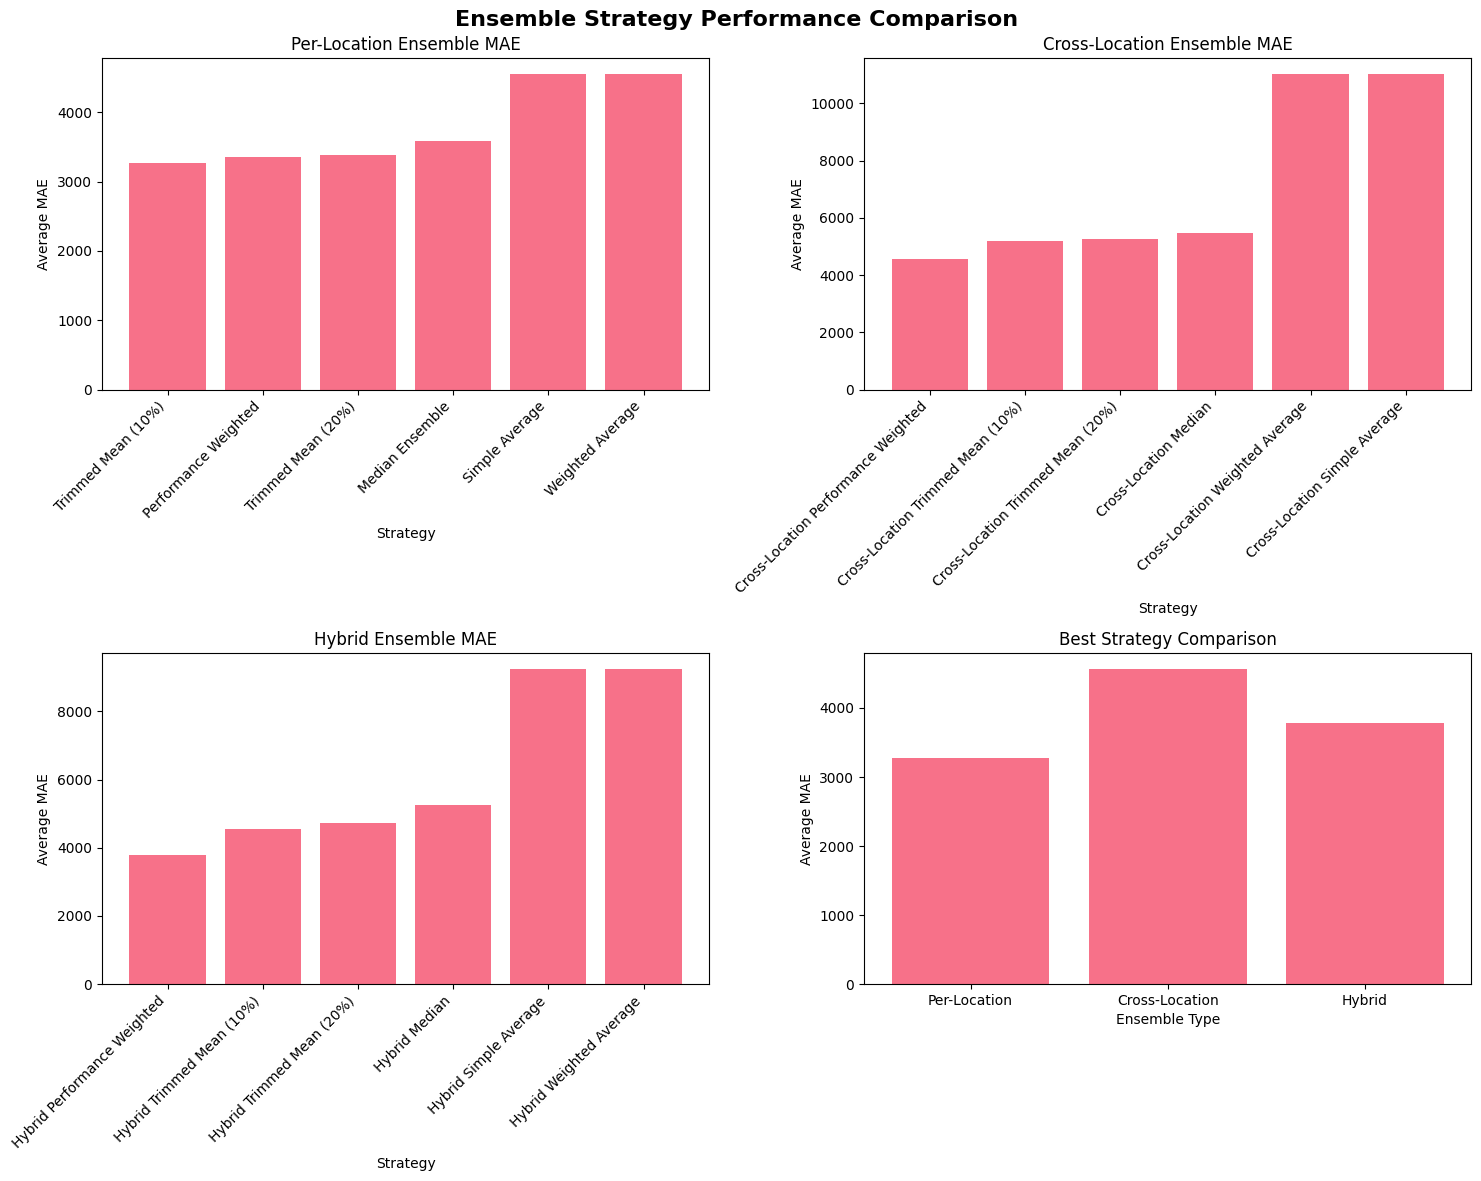

Strategy comparison plot saved!


In [11]:
# Create visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create output directory for plots
os.makedirs('../outputs/model_results/plots', exist_ok=True)

# 1. Strategy Performance Comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Ensemble Strategy Performance Comparison', fontsize=16, fontweight='bold')

# Per-location ensemble performance
per_location_mae = per_location_df.groupby('Strategy')['MAE'].mean().sort_values()
axes[0, 0].bar(range(len(per_location_mae)), per_location_mae.values)
axes[0, 0].set_title('Per-Location Ensemble MAE')
axes[0, 0].set_xlabel('Strategy')
axes[0, 0].set_ylabel('Average MAE')
axes[0, 0].set_xticks(range(len(per_location_mae)))
axes[0, 0].set_xticklabels(per_location_mae.index, rotation=45, ha='right')

# Cross-location ensemble performance
cross_location_mae = cross_location_df.groupby('Strategy')['MAE'].mean().sort_values()
axes[0, 1].bar(range(len(cross_location_mae)), cross_location_mae.values)
axes[0, 1].set_title('Cross-Location Ensemble MAE')
axes[0, 1].set_xlabel('Strategy')
axes[0, 1].set_ylabel('Average MAE')
axes[0, 1].set_xticks(range(len(cross_location_mae)))
axes[0, 1].set_xticklabels(cross_location_mae.index, rotation=45, ha='right')

# Hybrid ensemble performance
hybrid_mae = hybrid_df.groupby('Strategy')['MAE'].mean().sort_values()
axes[1, 0].bar(range(len(hybrid_mae)), hybrid_mae.values)
axes[1, 0].set_title('Hybrid Ensemble MAE')
axes[1, 0].set_xlabel('Strategy')
axes[1, 0].set_ylabel('Average MAE')
axes[1, 0].set_xticks(range(len(hybrid_mae)))
axes[1, 0].set_xticklabels(hybrid_mae.index, rotation=45, ha='right')

# Overall strategy comparison
strategy_mae = [best_per_location_mae, best_cross_location_mae, best_hybrid_mae]
strategy_names = ['Per-Location', 'Cross-Location', 'Hybrid']
axes[1, 1].bar(strategy_names, strategy_mae)
axes[1, 1].set_title('Best Strategy Comparison')
axes[1, 1].set_xlabel('Ensemble Type')
axes[1, 1].set_ylabel('Average MAE')

plt.tight_layout()
plt.savefig('../outputs/model_results/plots/ensemble_strategy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Strategy comparison plot saved!")


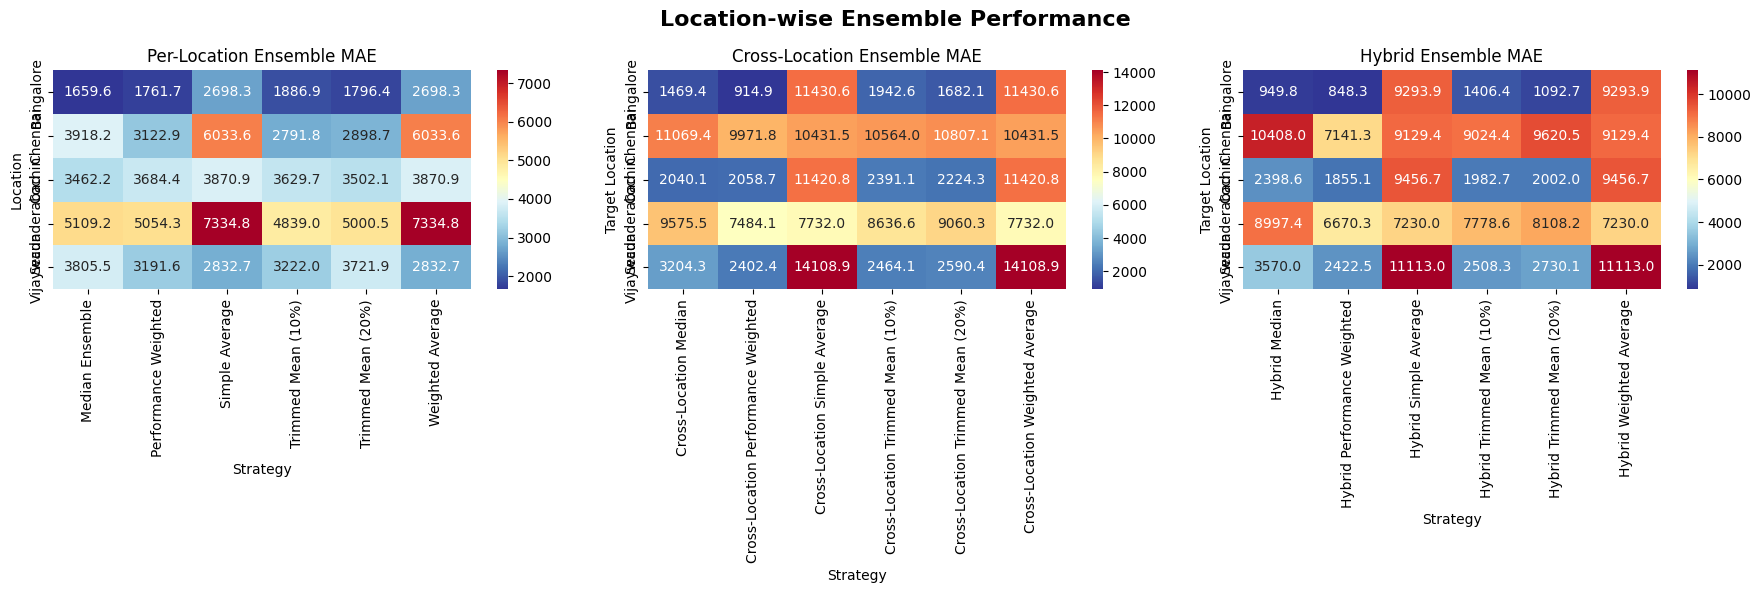

Location-wise performance heatmap saved!


In [12]:
# 2. Location-wise Performance Heatmap
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Location-wise Ensemble Performance', fontsize=16, fontweight='bold')

# Per-location performance heatmap
per_location_pivot = per_location_df.pivot_table(values='MAE', index='Location', columns='Strategy', aggfunc='mean')
sns.heatmap(per_location_pivot, annot=True, fmt='.1f', cmap='RdYlBu_r', ax=axes[0])
axes[0].set_title('Per-Location Ensemble MAE')
axes[0].set_xlabel('Strategy')
axes[0].set_ylabel('Location')

# Cross-location performance heatmap
cross_location_pivot = cross_location_df.pivot_table(values='MAE', index='Target_Location', columns='Strategy', aggfunc='mean')
sns.heatmap(cross_location_pivot, annot=True, fmt='.1f', cmap='RdYlBu_r', ax=axes[1])
axes[1].set_title('Cross-Location Ensemble MAE')
axes[1].set_xlabel('Strategy')
axes[1].set_ylabel('Target Location')

# Hybrid performance heatmap
hybrid_pivot = hybrid_df.pivot_table(values='MAE', index='Target_Location', columns='Strategy', aggfunc='mean')
sns.heatmap(hybrid_pivot, annot=True, fmt='.1f', cmap='RdYlBu_r', ax=axes[2])
axes[2].set_title('Hybrid Ensemble MAE')
axes[2].set_xlabel('Strategy')
axes[2].set_ylabel('Target Location')

plt.tight_layout()
plt.savefig('../outputs/model_results/plots/location_wise_ensemble_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("Location-wise performance heatmap saved!")


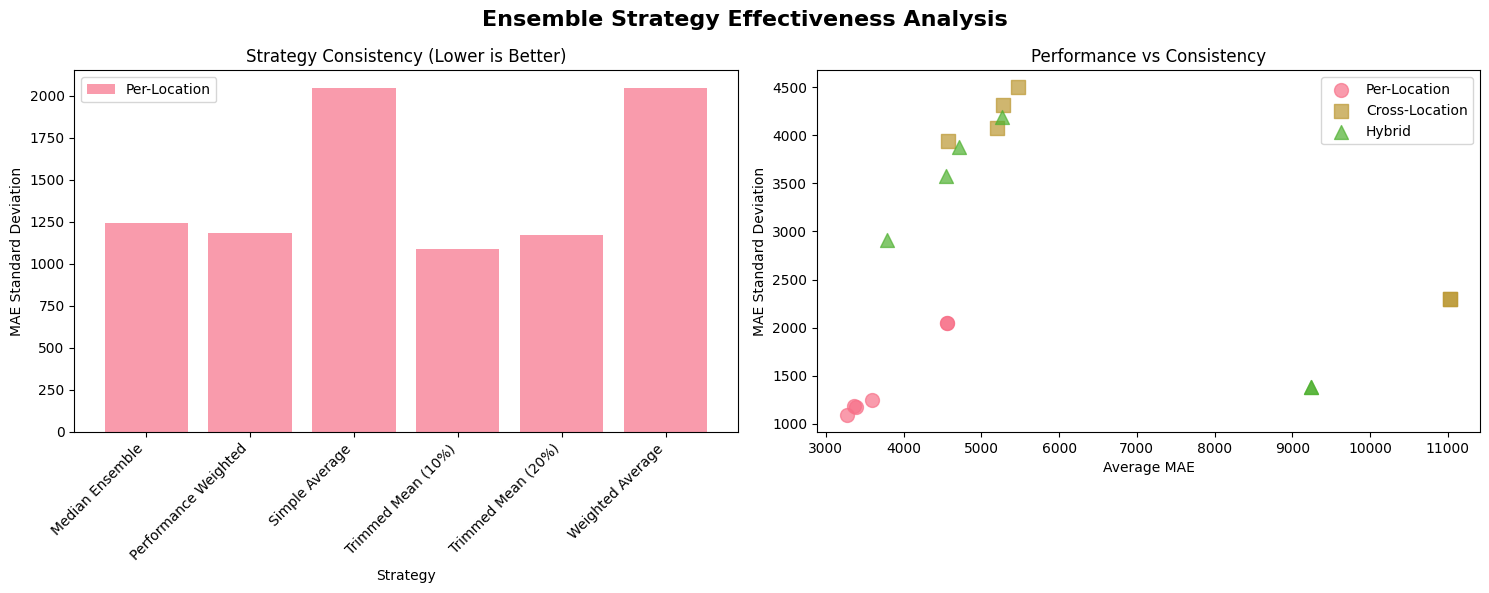

Strategy effectiveness analysis plot saved!


In [13]:
# 3. Strategy Effectiveness Analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Ensemble Strategy Effectiveness Analysis', fontsize=16, fontweight='bold')

# Strategy consistency (lower std = more consistent)
per_location_std = per_location_df.groupby('Strategy')['MAE'].std()
cross_location_std = cross_location_df.groupby('Strategy')['MAE'].std()
hybrid_std = hybrid_df.groupby('Strategy')['MAE'].std()

# Plot consistency
x_pos = range(len(per_location_std))
axes[0].bar(x_pos, per_location_std.values, alpha=0.7, label='Per-Location')
axes[0].set_title('Strategy Consistency (Lower is Better)')
axes[0].set_xlabel('Strategy')
axes[0].set_ylabel('MAE Standard Deviation')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(per_location_std.index, rotation=45, ha='right')
axes[0].legend()

# Performance vs Consistency scatter plot
per_location_mean = per_location_df.groupby('Strategy')['MAE'].mean()
axes[1].scatter(per_location_mean.values, per_location_std.values, 
               s=100, alpha=0.7, label='Per-Location', marker='o')
axes[1].scatter(cross_location_df.groupby('Strategy')['MAE'].mean().values, 
               cross_location_std.values, s=100, alpha=0.7, label='Cross-Location', marker='s')
axes[1].scatter(hybrid_df.groupby('Strategy')['MAE'].mean().values, 
               hybrid_std.values, s=100, alpha=0.7, label='Hybrid', marker='^')
axes[1].set_title('Performance vs Consistency')
axes[1].set_xlabel('Average MAE')
axes[1].set_ylabel('MAE Standard Deviation')
axes[1].legend()

plt.tight_layout()
plt.savefig('../outputs/model_results/plots/strategy_effectiveness_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Strategy effectiveness analysis plot saved!")


In [14]:
# Final Summary and Recommendations
print("\n" + "="*80)
print("ENSEMBLE ANALYSIS SUMMARY AND RECOMMENDATIONS")
print("="*80)

# 1. Overall Performance Summary
print("\n1. OVERALL PERFORMANCE SUMMARY")
print("-" * 50)
print(f"Best Per-Location Strategy: {best_per_location} (MAE: {best_per_location_mae:.2f})")
print(f"Best Cross-Location Strategy: {best_cross_location} (MAE: {best_cross_location_mae:.2f})")
print(f"Best Hybrid Strategy: {best_hybrid} (MAE: {best_hybrid_mae:.2f})")
print(f"Best Overall Strategy: {best_overall_strategy} (MAE: {best_overall_mae:.2f})")

# 2. Strategy Effectiveness Analysis
print("\n2. STRATEGY EFFECTIVENESS ANALYSIS")
print("-" * 50)

# Calculate improvement over individual models
if best_models is not None:
    individual_mae = best_models['MAE'].mean()
    ensemble_improvement = ((individual_mae - best_overall_mae) / individual_mae) * 100
    print(f"Individual Model Average MAE: {individual_mae:.2f}")
    print(f"Best Ensemble MAE: {best_overall_mae:.2f}")
    print(f"Ensemble Improvement: {ensemble_improvement:.2f}%")

# 3. Location-specific Recommendations
print("\n3. LOCATION-SPECIFIC RECOMMENDATIONS")
print("-" * 50)
for location in all_locations:
    print(f"\n{location}:")
    
    # Find best strategy for this location
    per_loc_best = per_location_df[per_location_df['Location'] == location]['MAE'].min()
    cross_loc_best = cross_location_df[cross_location_df['Target_Location'] == location]['MAE'].min()
    hybrid_loc_best = hybrid_df[hybrid_df['Target_Location'] == location]['MAE'].min()
    
    if not pd.isna(per_loc_best) and not pd.isna(cross_loc_best) and not pd.isna(hybrid_loc_best):
        best_loc_strategy = min([
            ('Per-Location', per_loc_best),
            ('Cross-Location', cross_loc_best),
            ('Hybrid', hybrid_loc_best)
        ], key=lambda x: x[1])
        
        print(f"  Recommended: {best_loc_strategy[0]} (MAE: {best_loc_strategy[1]:.2f})")
        
        # Show all options
        print(f"  Per-Location: {per_loc_best:.2f}")
        print(f"  Cross-Location: {cross_loc_best:.2f}")
        print(f"  Hybrid: {hybrid_loc_best:.2f}")

# 4. Ensemble Strategy Insights
print("\n4. ENSEMBLE STRATEGY INSIGHTS")
print("-" * 50)

# Analyze which strategies work best
strategy_rankings = {
    'Per-Location': per_location_df.groupby('Strategy')['MAE'].mean().rank(),
    'Cross-Location': cross_location_df.groupby('Strategy')['MAE'].mean().rank(),
    'Hybrid': hybrid_df.groupby('Strategy')['MAE'].mean().rank()
}

print("Strategy Rankings (1 = Best):")
for ensemble_type, rankings in strategy_rankings.items():
    print(f"\n{ensemble_type}:")
    for strategy, rank in rankings.sort_values().items():
        print(f"  {strategy}: {rank:.1f}")

# 5. Practical Recommendations
print("\n5. PRACTICAL RECOMMENDATIONS")
print("-" * 50)
print("1. For Production Deployment:")
print(f"   - Use {best_overall_strategy} ensemble with {best_overall_mae:.2f} MAE")
print("   - Implement dynamic weighting based on recent performance")
print("   - Monitor model performance and retrain periodically")

print("\n2. For Different Scenarios:")
print("   - New locations with limited data: Use Cross-Location ensemble")
print("   - Established locations with rich data: Use Per-Location ensemble")
print("   - Maximum accuracy: Use Hybrid ensemble")

print("\n3. Implementation Strategy:")
print("   - Start with Simple Average for baseline")
print("   - Upgrade to Performance Weighted for better accuracy")
print("   - Consider Trimmed Mean for robustness against outliers")

print("\n4. Monitoring and Maintenance:")
print("   - Track ensemble performance vs individual models")
print("   - Implement automated retraining when performance degrades")
print("   - Use cross-validation for ensemble weight optimization")

print(f"\n{'='*80}")
print("ENSEMBLE ANALYSIS COMPLETED SUCCESSFULLY!")
print(f"{'='*80}")



ENSEMBLE ANALYSIS SUMMARY AND RECOMMENDATIONS

1. OVERALL PERFORMANCE SUMMARY
--------------------------------------------------
Best Per-Location Strategy: Trimmed Mean (10%) (MAE: 3273.86)
Best Cross-Location Strategy: Cross-Location Performance Weighted (MAE: 4566.38)
Best Hybrid Strategy: Target_Location                      Vijaywada
Strategy           Hybrid Performance Weighted
MAE                                2422.450362
RMSE                               3407.575138
MAPE                                 37.666437
R2                                    0.204852
Name: 26, dtype: object (MAE: 3787.48)
Best Overall Strategy: Per-Location (MAE: 3273.86)

2. STRATEGY EFFECTIVENESS ANALYSIS
--------------------------------------------------
Individual Model Average MAE: 2850.51
Best Ensemble MAE: 3273.86
Ensemble Improvement: -14.85%

3. LOCATION-SPECIFIC RECOMMENDATIONS
--------------------------------------------------

Bangalore:
  Recommended: Hybrid (MAE: 848.27)
  Per-Location